# Análise Exploratória 

In [5]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import folium

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from database.connection import connection
from database.engine import engine
from database.fetch_bus_data import fetch_bus_data
from database.get_table_structure import get_table_structure
from IPython.display import display
from visualization.plot_bus_route import plot_bus_route
from visualization.save_folium_as_png import save_folium_as_png


In [6]:
def add_waiting_time(bus_data):
    """ Adiciona uma coluna de tempo de espera para cada veículo que cresce enquanto a velocidade é zero.

    Fazendo-se a média dos valores para um veículo, ou para um local do mapa e multiplicando-se por 2 obtém-se aproximadamente o tempo de espera médio.
    OBS: Há um erro nesta função porque quando passa-se de um veículo para outro, o contador não é zerado, mas não importa, o efeito é pequeno.
    """

    bus_data = bus_data.sort_values(['ordem', 'datahoraservidor']).copy()
    bus_data['tempo_espera'] = 0

    for ordem, group in bus_data.groupby('ordem'):
        idxs = group.index
        espera = 0
        for i, idx in enumerate(idxs):
            if group.loc[idx, 'velocidade'] == 0:
                espera = espera + 1 if i > 0 else 1
            else:
                espera = 0
            bus_data.loc[idx, 'tempo_espera'] = espera


    return bus_data

from shapely.geometry import box
import matplotlib.colors as mcolors

def get_grid(bus_data, grid_size_graus, waiting_threshold=60):
    # Não faz reprojeção, trabalha no CRS original (ex: epsg:4326)
    minx, miny, maxx, maxy = bus_data.total_bounds

    # Cria o grid em graus (aproximação grosseira: 0.001 ~ 100m na linha do Equador)
    x_coords = np.arange(minx, maxx + grid_size_graus, grid_size_graus)
    y_coords = np.arange(miny, maxy + grid_size_graus, grid_size_graus)
    grid = []
    for x in x_coords:
        for y in y_coords:
            grid.append(box(x, y, x + grid_size_graus, y + grid_size_graus))
    grid_gdf = gpd.GeoDataFrame({'geometry': grid}, crs=bus_data.crs)

    # Faz o spatial join para contar pontos em cada célula do grid
    join = gpd.sjoin(bus_data, grid_gdf, how='left', predicate='within')

    densidade = join.groupby('index_right').size()
    mediana_velocidade = join.groupby('index_right')['velocidade'].median()
    media_tempo_espera = join.groupby('index_right')['tempo_espera'].mean()*2

    grid_gdf['densidade'] = densidade.reindex(grid_gdf.index).fillna(0).astype(int)
    grid_gdf['mediana_velocidade'] = mediana_velocidade.reindex(grid_gdf.index).fillna(np.nan)
    grid_gdf['media_tempo_espera'] = media_tempo_espera.reindex(grid_gdf.index).fillna(0).astype(int)
    grid_gdf['candidato_ponto_final'] = (
        (grid_gdf['densidade'] > 0)
        # & (grid_gdf['mediana_velocidade'] <= 0)
        & (grid_gdf['media_tempo_espera'] > waiting_threshold)
    )#.astype(int)

    return grid_gdf



## Estado do banco de dados

In [7]:
# Exemplo de uso
table_structure = get_table_structure()
print(table_structure)


        column_name                    data_type  nullable
0                id                      integer  NOT NULL
1             ordem                         text      NULL
2              geom        geography(Point,4326)      NULL
3          datahora  timestamp without time zone  NOT NULL
4        velocidade             double precision      NULL
5             linha                         text      NULL
6     datahoraenvio  timestamp without time zone      NULL
7  datahoraservidor  timestamp without time zone      NULL


## Visualização dos dados de uma linha

Buscando linha 457...
Plotando pontos da linha 457...


/tmp/ipykernel_64390/70046879.py:14: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  bus_data.plot(column='id', figsize=(10, 10), markersize=30, color='red', alpha=min(1, 50/num_of_points))


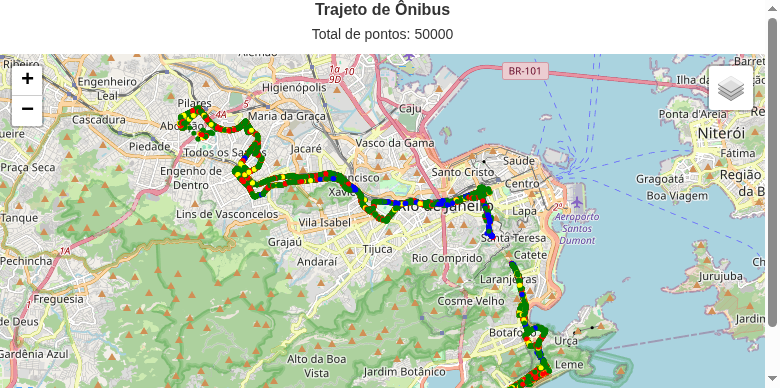

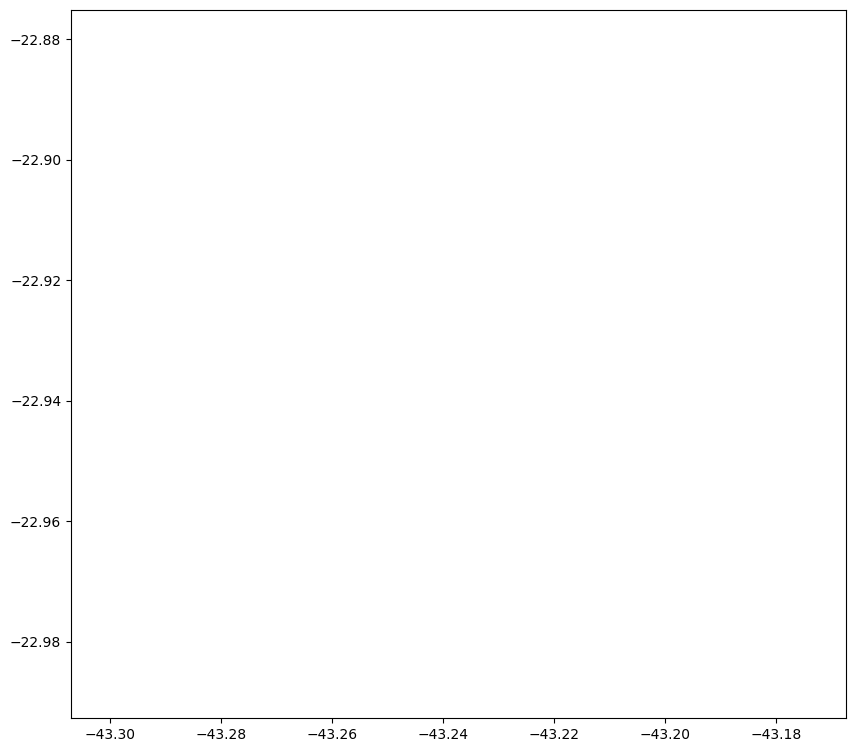

In [8]:
from IPython.display import Image

linha = '457'
num_of_points = 50000  # Para pegar todos os pontos, ou pode definir um número específico, ex: 10000

print(f"Buscando linha {linha}...")

bus_data = fetch_bus_data(engine, linha, limit=num_of_points)
bus_data = add_waiting_time(bus_data)
bus_data.head()

print(f"Plotando pontos da linha {linha}...")

bus_data.plot(column='id', figsize=(10, 10), markersize=30, color='red', alpha=min(1, 50/num_of_points))

mapa = plot_bus_route(bus_data)
mapa.save(f'../../output/trajectories/HTML/{linha}.html')

# # Exibir o mapa no Jupyter Notebook (pesado para mais de 10k pontos))
# display(mapa)

# Salvar o mapa como PNG e exibe (versão mais leve do que o interativo)
save_folium_as_png(mapa, f'../../output/trajectories/PNG/{linha}.png')
display(Image(filename=f'../../output/trajectories/PNG/{linha}.png'))

### Tempo de espera

Text(0.5, 1.0, 'Tempo de espera dos ônibus da linha 457')

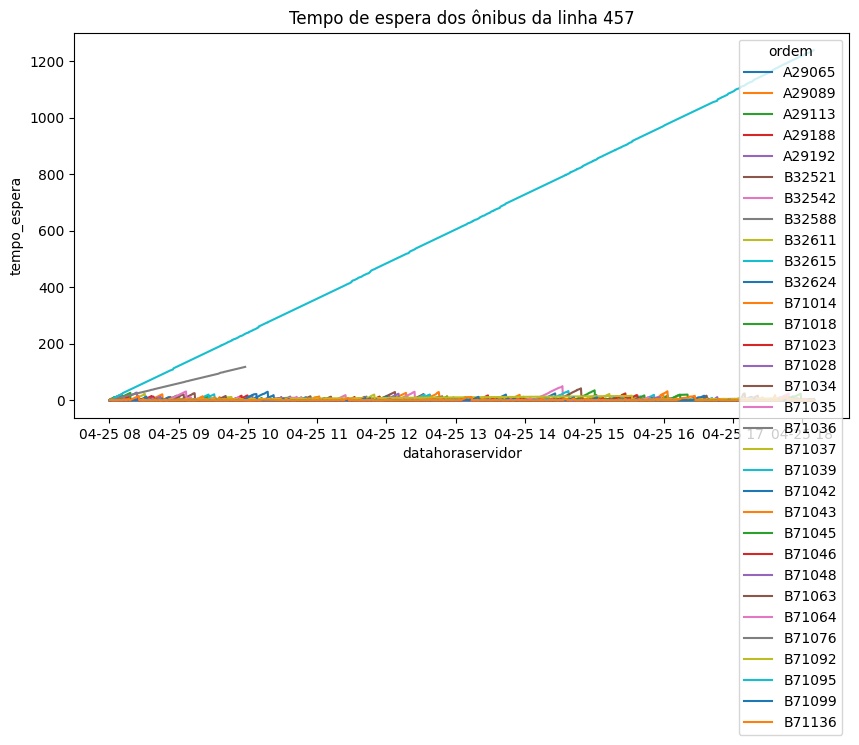

In [9]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=bus_data, x='datahoraservidor', y='tempo_espera', hue='ordem', palette='tab10')
plt.title(f'Tempo de espera dos ônibus da linha {linha}')


### Visualizar os dados agrupados em um grid discreto

Cria um grid com várias propriedades para exibi-las em forma de heatmap. Um ponto azul no primeiro gráfico indica a posição do ponto que foi atribuído como ponto final.

Densidade máxima: 1438
Centro da célula: -43.30057 -22.885790000000235


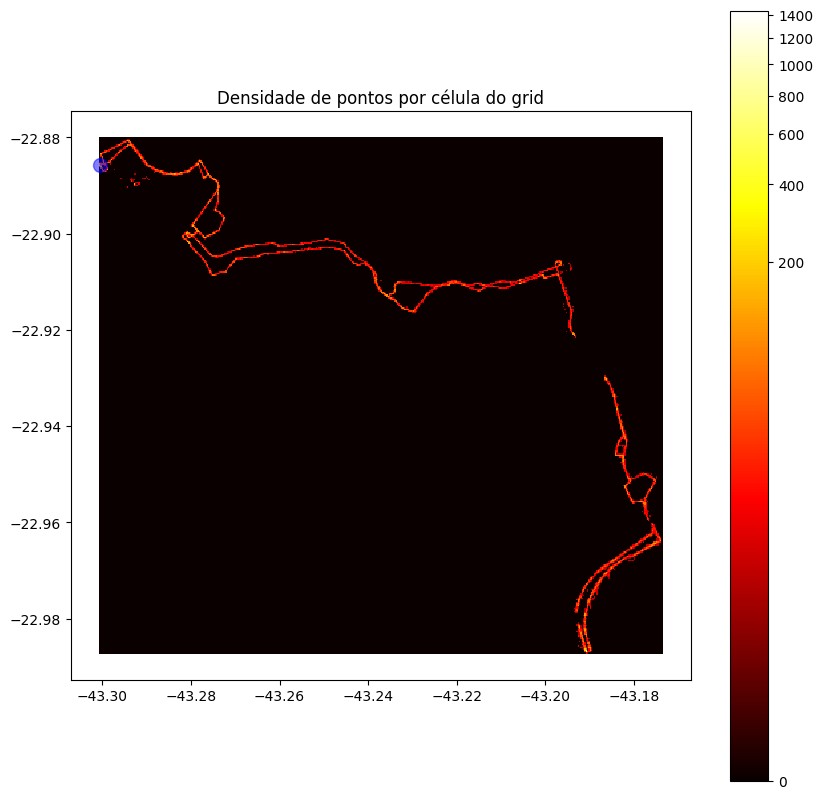

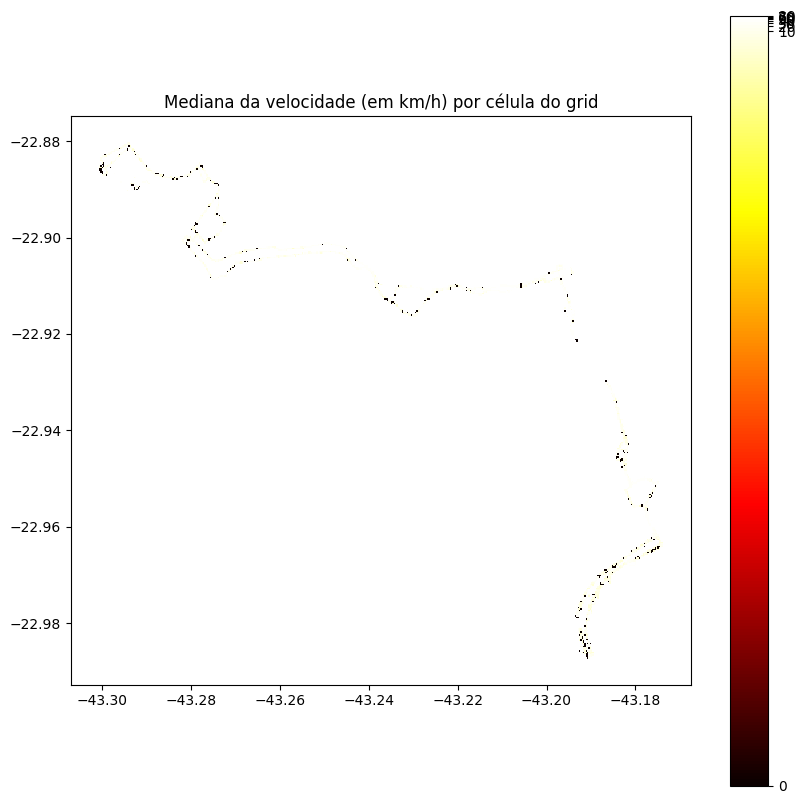

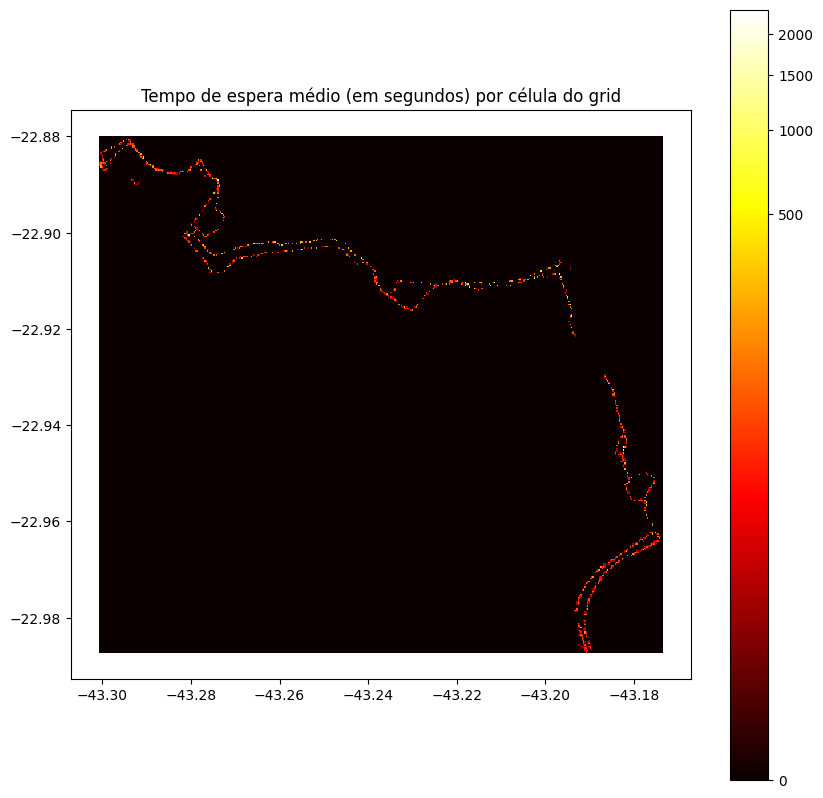

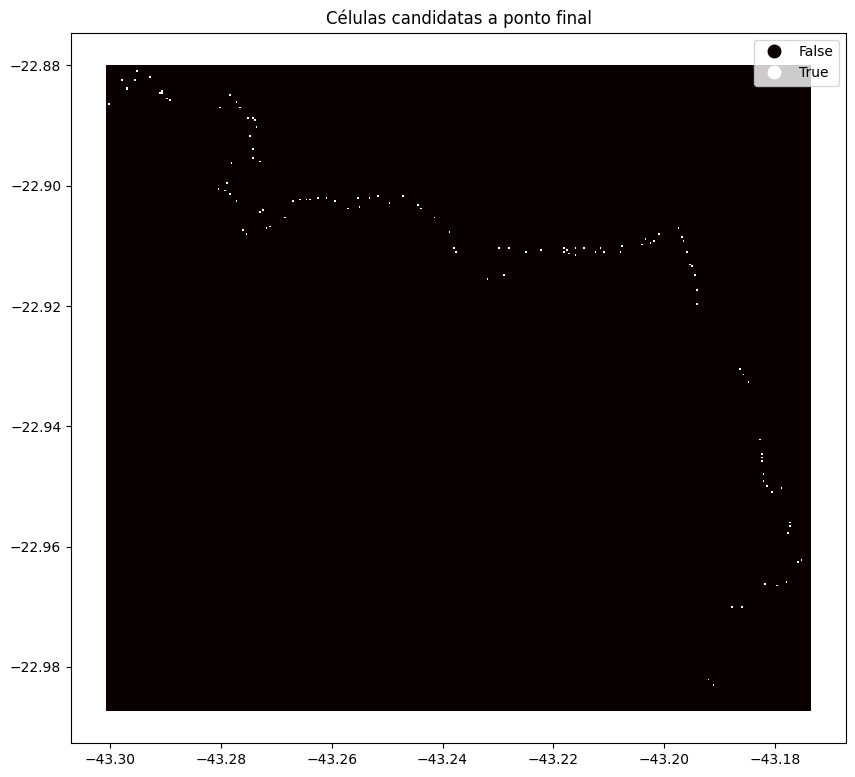

In [10]:
grid = get_grid(bus_data, grid_size_graus=0.0003, waiting_threshold=180)

# Para obter o centro da célula (como ponto)
idx_maior_densidade = grid['densidade'].idxmax()
celula_maior_densidade = grid.loc[idx_maior_densidade]
centro = celula_maior_densidade.geometry.centroid

print("Densidade máxima:", celula_maior_densidade['densidade'])
print("Centro da célula:", centro.x, centro.y)

grid.plot(column='densidade', cmap='hot', legend=True, figsize=(10, 10), norm=mcolors.PowerNorm(gamma=0.2))
plt.scatter([centro.x], [centro.y], color='blue', alpha=0.5, s=100, marker='o', label='Centro de maior densidade')
plt.title('Densidade de pontos por célula do grid')
plt.show()

grid.plot(column='mediana_velocidade', cmap='hot', legend=True, figsize=(10, 10), norm=mcolors.PowerNorm(gamma=0.01))
plt.title('Mediana da velocidade (em km/h) por célula do grid')
plt.show()

grid.plot(column='media_tempo_espera', cmap='hot', legend=True, figsize=(10, 10), norm=mcolors.PowerNorm(gamma=0.2))
plt.title('Tempo de espera médio (em segundos) por célula do grid')
plt.show()

grid.plot(column='candidato_ponto_final', cmap='hot', legend=True, figsize=(10, 10))
plt.title('Células candidatas a ponto final')
plt.show()



In [12]:
# from shapely.geometry import LineString

# # Ordena os pontos pelo tempo (ou outro critério desejado)
# bus_data_sorted = bus_data.sort_values(['ordem', 'datahoraservidor'])

# # Extrai as coordenadas dos pontos
# coords = [(geom.x, geom.y) for geom in bus_data_sorted.geometry]

# # Cria a LineString
# linha_shape = LineString(coords)

# # Para visualizar ou salvar como GeoDataFrame:
# import geopandas as gpd
# linha_gdf = gpd.GeoDataFrame({'linha': [linha], 'geometry': [linha_shape]}, crs=bus_data.crs)

# # Exemplo de plot
# linha_gdf.plot(figsize=(10, 10), color='blue')

## Discussão

Para este trabalho, buscamos uma abordagem totalmente baseada em dados para prever a posição do ônibus ou seu instante de tempo, para esta modelagem nao necessariamente precisamos encontrar corretamente.

Verificamos que a maneira mais eficiente de encontrar o ponto final é apenas verificar a densidade em horários durante o dia que minimizam a chance de o ônibus estar na garagem, considerando um intervalo de tempo de vários dias. Com estas condições o trajeto também é fácil de determinar.
